## Importing the required modules & libraries
we start with importing all the required libraries and modules.

In [1]:
import os
import torch
import torchvision
import pandas as pd
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import  Image
from torch.utils.data.dataloader import DataLoader

transfromation to be applied on the dataset.<br>
* Resize to get (32, 32) image size<br>
* ToTensor to transform the inpity image data into pytroch tensor<br>
* Normalize the data

In [2]:
transformations=transforms.Compose([transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.3337, 0.3064, 0.3171),(0.2627, 0.2564, 0.2629))])

## Exploring the Data
> 
> We are using "gtsrb-german-traffic-sign" dataset.<br>
* Dataset consist of traffic sign images.<br>
* These images are classified in 43 classes.
* These categories are labeled from 0 - 42.<br>
* Training Dataset consists of 39209 images.<br>
* Test Dataset consists of 12630 images.<br>


In [3]:
data_dir = '../input/gtsrb-german-traffic-sign/Train'

print(list(os.listdir(data_dir)))

['41', '6', '4', '9', '39', '17', '33', '36', '32', '34', '13', '38', '29', '2', '18', '8', '1', '20', '7', '35', '40', '21', '10', '31', '12', '24', '5', '27', '25', '16', '23', '0', '11', '19', '3', '26', '42', '15', '37', '28', '30', '22', '14']


Loading the dataset using ImageFolder from torchvision and applied transformation.

In [4]:
dataset = ImageFolder(data_dir, transform=transformations)
print(type(dataset))
print('dataset size: ',len(dataset))
x, y=dataset[0]
print('label: ',y)
print('Image Shape: ',x.shape,'\n')
print(x)

<class 'torchvision.datasets.folder.ImageFolder'>
dataset size:  39209
label:  0
Image Shape:  torch.Size([3, 32, 32]) 

tensor([[[-0.1507, -0.1656, -0.0313,  ..., -0.2701, -0.3000, -0.2850],
         [-0.0462, -0.0910,  0.0434,  ..., -0.1805, -0.1357, -0.0910],
         [-0.0910, -0.0163,  0.0882,  ..., -0.1955, -0.1656, -0.1059],
         ...,
         [ 0.6106,  0.5062,  0.3419,  ...,  0.1777,  0.2076,  0.2076],
         [ 0.0732,  0.0882, -0.1208,  ...,  0.2972,  0.3270,  0.1479],
         [-0.0014,  0.1330, -0.2402,  ...,  0.2375,  0.1927,  0.0732]],

        [[-0.0020, -0.0326,  0.0897,  ..., -0.0632, -0.1397, -0.1703],
         [ 0.0745,  0.0439,  0.1356,  ..., -0.0173, -0.0173,  0.0133],
         [ 0.0133,  0.0897,  0.1662,  ..., -0.0632, -0.0479, -0.0020],
         ...,
         [ 0.7627,  0.6862,  0.5945,  ...,  0.2733,  0.3498,  0.3803],
         [ 0.2427,  0.3039,  0.1356,  ...,  0.3956,  0.5027,  0.3803],
         [ 0.0897,  0.3192,  0.0286,  ...,  0.3651,  0.3498,  0.2886

In [5]:
print('Classes: ',dataset.classes)
classes=dataset.classes

Classes:  ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


Function to show a single image using imshow from matplotlib.pyplot

In [6]:
def showSingleImage(img, label):
    print('Label: ', dataset.classes[label],)
    plt.imshow(img.permute(1, 2, 0))

Label:  0


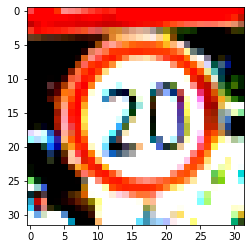

In [7]:
showSingleImage(*dataset[50])

Label:  11


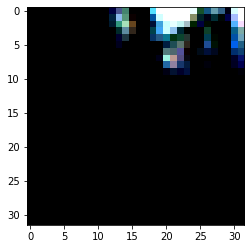

In [8]:
showSingleImage(*dataset[5000])

Label:  4


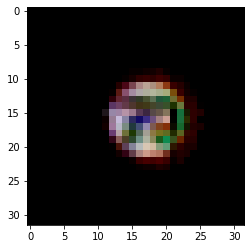

In [9]:
showSingleImage(*dataset[30000])

## Training and Validation Datasets

Split the dataset into training and validation dataset.
Test Dataset is given.
1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (9209 images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [10]:
random_seed = 20
torch.manual_seed(random_seed);

In [11]:
val_size = 9209
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
print('Train Dataset size: ',len(train_ds))
print('Validation Dataset Size:',len(val_ds))


Train Dataset size:  30000
Validation Dataset Size: 9209


Defined the batch size for the dataset.

In [12]:
batch_size=200

In [13]:
train_dl=DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl=DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)

Function to show a batch of images using make_grid from torchvision.

In [14]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, axs = plt.subplots(figsize=(20, 20))
        axs.set_xticks([]) 
        axs.set_yticks([])
        axs.imshow(make_grid(images, nrow=20).permute(1, 2, 0))
        break

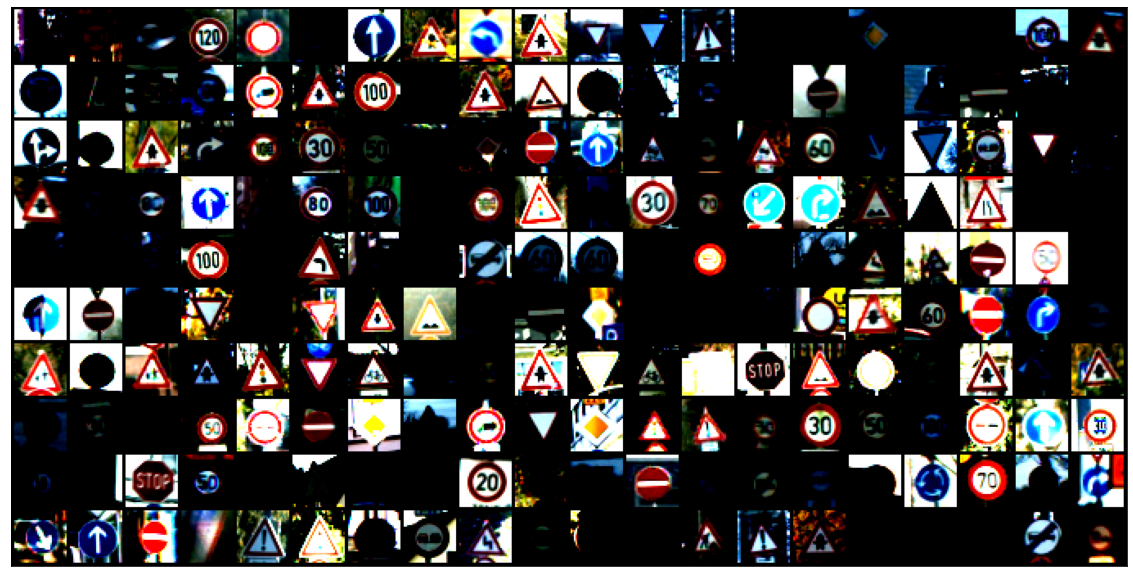

In [15]:
show_batch(train_dl)

## Defining the Model (Convolutional Neural Network)

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss


    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

## model definition

In [17]:
class MyCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(3, 64, kernel_size=5)
        self.bn1=nn.BatchNorm2d(64)
        self.pool=nn.MaxPool2d(2, 2)
        self.conv2=nn.Conv2d(64, 128, kernel_size=3)
        self.bn2=nn.BatchNorm2d(128)
        self.conv3=nn.Conv2d(128, 256, kernel_size=1)
        self.bn3=nn.BatchNorm2d(256)
        self.la1=nn.Linear(256*3*3, 512)
        self.bn4=nn.BatchNorm1d(512)
        self.la2=nn.Linear(512, 128)
        self.bn5=nn.BatchNorm1d(128)
        self.la3=nn.Linear(128, 43)
        self.dropout=nn.Dropout(p=0.25)
        
        
    def forward(self, xb):
        xb=self.pool(F.elu(self.conv1(xb)))
        xb=self.dropout(self.bn1(xb))
        xb=self.pool(F.elu(self.conv2(xb)))
        xb=self.dropout(self.bn2(xb))
        xb=self.pool(F.elu(self.conv3(xb)))
        xb=self.dropout(self.bn3(xb))
        xb=xb.view(-1, 256*3*3)
        xb=self.la1(xb)
        xb=F.elu(xb)
        xb=self.dropout(self.bn4(xb))
        xb=self.la2(xb)
        xb=F.elu(xb)
        xb=self.dropout(self.bn5(xb))
        xb=self.la3(xb)
        return xb

In [18]:
mymodel=MyCnnModel()
mymodel

MyCnnModel(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (la1): Linear(in_features=2304, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (la2): Linear(in_features=512, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (la3): Linear(in_features=128, out_features=43, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

load the data and the model to the device available.

In [19]:
from torch import device
from torch import cuda
def get_default_device():
    """Pick GPU if available, else CPU"""
    if cuda.is_available():
        return device('cuda')
    else:
        return device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [20]:
device = get_default_device()
device

device(type='cuda')

In [21]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(mymodel, device);

In [22]:
def try_batch(dl):
    for images, labels in dl:
        print('images.shape:', images.shape)
        out = mymodel(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[0])
        break

try_batch(train_dl)

images.shape: torch.Size([200, 3, 32, 32])
out.shape: torch.Size([200, 43])
out[0]: tensor([-0.5122, -0.5461,  0.3031,  0.7885,  0.5232, -0.7032, -1.3946,  0.8036,
        -0.2109,  0.1126, -0.2257, -0.1377, -1.3767,  0.3902, -0.6437, -0.6959,
        -0.3758,  1.0891, -0.3786,  0.6321,  1.0479,  0.3831,  0.2911, -0.2427,
         1.0628,  1.0227, -0.9600,  0.5735, -0.5587, -0.4165,  0.5364,  1.8864,
         0.1162,  0.3693,  0.0424,  0.2968,  0.4769,  0.7029, -0.2731,  0.0581,
        -0.2280, -0.0057, -0.0819], device='cuda:0', grad_fn=<SelectBackward>)


In [23]:
from tqdm.notebook import tqdm

In [24]:
@torch.no_grad()
def evaluate(mymodel, val_loader):
    mymodel.eval()
    outputs = [mymodel.validation_step(batch) for batch in val_loader]
    return mymodel.validation_epoch_end(outputs)

def fit(epochs, lr, mymodel, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(mymodel.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        mymodel.train()
        train_losses = []
        for batch in train_loader:
            loss = mymodel.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(mymodel, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        mymodel.epoch_end(epoch, result)
        history.append(result)
    return history

In [25]:
mymodel = to_device(MyCnnModel(), device)

In [26]:
evaluate(mymodel, val_dl)

{'val_loss': 3.769653797149658, 'val_acc': 0.026914888992905617}

# Training

In [27]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 1e-3

history = fit(num_epochs, lr, mymodel, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.1464, val_loss: 0.2239, val_acc: 0.9591
Epoch [1], train_loss: 0.2346, val_loss: 0.0747, val_acc: 0.9862
Epoch [2], train_loss: 0.1167, val_loss: 0.0377, val_acc: 0.9905
Epoch [3], train_loss: 0.0769, val_loss: 0.0326, val_acc: 0.9906
Epoch [4], train_loss: 0.0570, val_loss: 0.0264, val_acc: 0.9926
Epoch [5], train_loss: 0.0419, val_loss: 0.0180, val_acc: 0.9963
Epoch [6], train_loss: 0.0363, val_loss: 0.0202, val_acc: 0.9938
Epoch [7], train_loss: 0.0317, val_loss: 0.0175, val_acc: 0.9952


In [28]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 1e-4

history += fit(num_epochs, lr, mymodel, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0176, val_loss: 0.0086, val_acc: 0.9980
Epoch [1], train_loss: 0.0101, val_loss: 0.0074, val_acc: 0.9981
Epoch [2], train_loss: 0.0090, val_loss: 0.0076, val_acc: 0.9981


In [29]:
num_epochs = 3
opt_func = torch.optim.Adam
lr = 1e-5

history += fit(num_epochs, lr, mymodel, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0077, val_loss: 0.0072, val_acc: 0.9984
Epoch [1], train_loss: 0.0077, val_loss: 0.0070, val_acc: 0.9983
Epoch [2], train_loss: 0.0076, val_loss: 0.0070, val_acc: 0.9983


## Plotting Accuracy

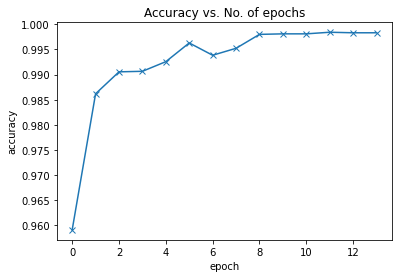

In [30]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
    
plot_accuracies(history)

## Plotting Loss

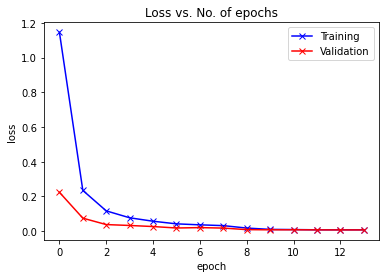

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)    

In [32]:
print(len(classes))
print(classes)

43
['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


## Evaluation on Test Dataset

In [33]:
test_file=pd.read_csv('../input/gtsrb-german-traffic-sign/Test.csv')
print('test data size: ',len(test_file))

path='../input/gtsrb-german-traffic-sign/'

count=0
size=len(test_file)
for i in range(size):
    k=test_file.iloc[i]
    showim=Image.open(path+k[7])

    image=showim
    image=transformations(image)
    
    image=image.unsqueeze(0)
    image = DataLoader(image, 1, pin_memory=True)
    image = DeviceDataLoader(image, device)
    
    for x in image:
        x=x
     
    image=x
    
    pred=mymodel(image)
    ans1=torch.max(pred, dim=1)[1].item()
    ans1=int(classes[ans1])
    ans2=k[6]
    if(ans1==ans2):
       count+=1  
print('successful prediction: ',count)    
test_accuracy=count*100/size

test data size:  12630
successful prediction:  12296


## Test Accuracy

In [34]:
print("Accuracy on Test Data: ",test_accuracy)

Accuracy on Test Data:  97.35550277117973


In [35]:
!pip install jovian --upgrade -q

In [36]:
import jovian

<IPython.core.display.Javascript object>

In [37]:
project_name='Traffic_Sign_Classification'
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/shazaibahmad3/Traffic_Sign_Classification


<IPython.core.display.Javascript object>